Training Original Mini-GPT...
Epoch 0, Loss 3.5052
Epoch 50, Loss 1.7916
Epoch 100, Loss 0.8522
Epoch 150, Loss 0.4323
Epoch 200, Loss 0.3096
Epoch 250, Loss 0.2570
Epoch 300, Loss 0.3610
Epoch 350, Loss 0.3327
Epoch 400, Loss 0.2502
Epoch 450, Loss 0.2790
Epoch 500, Loss 0.2522
Epoch 550, Loss 0.3385
Epoch 600, Loss 0.1939
Epoch 650, Loss 0.2478
Epoch 700, Loss 0.2748
Epoch 750, Loss 0.1600
Epoch 800, Loss 0.2367
Epoch 850, Loss 0.2949
Epoch 900, Loss 0.2360
Epoch 950, Loss 0.2126

Training Deep-and-Thin Mini-GPT...
Epoch 0, Loss 3.6009
Epoch 50, Loss 2.1447
Epoch 100, Loss 1.4059
Epoch 150, Loss 1.2241
Epoch 200, Loss 1.0578
Epoch 250, Loss 0.6741
Epoch 300, Loss 0.6134
Epoch 350, Loss 0.4707
Epoch 400, Loss 0.5362
Epoch 450, Loss 0.5328
Epoch 500, Loss 0.3510
Epoch 550, Loss 0.3140
Epoch 600, Loss 0.2717
Epoch 650, Loss 0.2971
Epoch 700, Loss 0.2419
Epoch 750, Loss 0.3332
Epoch 800, Loss 0.4232
Epoch 850, Loss 0.3516
Epoch 900, Loss 0.3240
Epoch 950, Loss 0.2126

===== Comparison ==

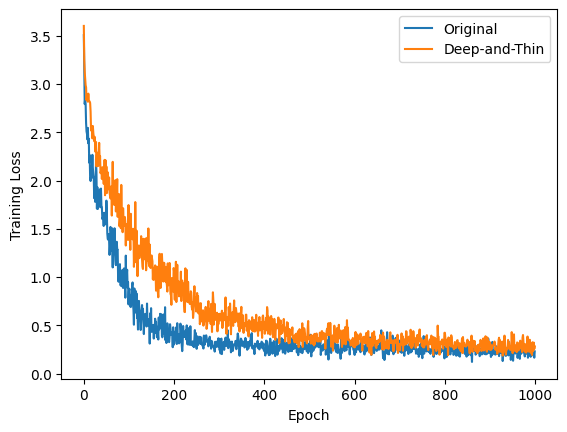


Generated by Original Mini-GPT:
 Alice who loved adventures. Every day, she would explore the forest, discovering new secrets and magical c

Generated by Deep-and-Thin Mini-GPT:
 Alice who loved adventures. Every day, she would explore the forest, disering new secrets and magical crea


In [ ]:
# ================================
# Compare Mini-GPT vs Deep-and-Thin
# ================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

# ------------------
# 1️⃣ Set seeds
# ------------------
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ------------------
# 2️⃣ Sample story dataset
# ------------------
story_text = (
    "Once upon a time, in a land far away, there was a small village. "
    "In this village, lived a young girl named Alice who loved adventures. "
    "Every day, she would explore the forest, discovering new secrets and magical creatures. "
    "One day, she stumbled upon a mysterious door hidden behind the trees."
)

chars = sorted(list(set(story_text)))
vocab_size = len(chars)
stoi = {c:i for i,c in enumerate(chars)}
itos = {i:c for c,i in stoi.items()}

def encode(s):
    return [stoi[c] for c in s]

def decode(l):
    return "".join([itos[i] for i in l])

data = torch.tensor(encode(story_text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# ------------------
# 3️⃣ Data loader
# ------------------
def get_batch(data, batch_size, block_size):
    ix = torch.randint(len(data)-block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# ------------------
# 4️⃣ Transformer building blocks
# ------------------
class Head(nn.Module):
    def __init__(self, head_size, embedding_dim, block_size):
        super().__init__()
        self.key = nn.Linear(embedding_dim, head_size, bias=False)
        self.query = nn.Linear(embedding_dim, head_size, bias=False)
        self.value = nn.Linear(embedding_dim, head_size, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        v = self.value(x)
        return wei @ v

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, embedding_dim, dropout, block_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, embedding_dim, block_size) for _ in range(num_heads)])
        self.proj = nn.Linear(num_heads*head_size, embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, embedding_dim, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, 4*embedding_dim),
            nn.ReLU(),
            nn.Linear(4*embedding_dim, embedding_dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, embedding_dim, n_heads, dropout, block_size):
        super().__init__()
        head_size = embedding_dim // n_heads
        self.sa = MultiHeadAttention(n_heads, head_size, embedding_dim, dropout, block_size)
        self.ffwd = FeedForward(embedding_dim, dropout)
        self.ln1 = nn.LayerNorm(embedding_dim)
        self.ln2 = nn.LayerNorm(embedding_dim)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# ------------------
# 5️⃣ Mini-GPT class
# ------------------
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_layers, n_heads, block_size, dropout):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding_table = nn.Embedding(block_size, embedding_dim)
        self.blocks = nn.Sequential(*[Block(embedding_dim, n_heads, dropout, block_size) for _ in range(n_layers)])
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.lm_head = nn.Linear(embedding_dim, vocab_size)
        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        # Fix: Cast idx to long tensor
        idx = idx.to(torch.long)
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B*T, C), targets.view(B*T))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            next_idx = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_idx), dim=1)
        return idx

# ------------------
# 6️⃣ Training + evaluation helper
# ------------------
def train_model(config, train_data, val_data, epochs=200):
    model = MiniGPT(
        vocab_size=vocab_size,
        embedding_dim=config['embedding_dim'],
        n_layers=config['n_layers'],
        n_heads=config['n_heads'],
        block_size=config['block_size'],
        dropout=config['dropout']
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    train_losses = []
    for epoch in range(epochs):
        xb, yb = get_batch(train_data, config['batch_size'], config['block_size'])
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.4f}")
    # Compute perplexity
    xb, yb = get_batch(val_data, config['batch_size'], config['block_size'])
    with torch.no_grad():
        _, val_loss = model(xb, yb)
    perplexity = torch.exp(val_loss).item()
    # Parameters
    param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return model, train_losses, val_loss.item(), perplexity, param_count

# ------------------
# 7️⃣ Configs
# ------------------
block_size = 16
dropout = 0.1
batch_size = 8
lr = 1e-2
epochs = 1000

# Original mini-GPT (baseline)
original_config = {
    'embedding_dim': 64,
    'n_layers': 2,
    'n_heads': 4,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

# Deep-and-Thin (MobileLLM)
deepthin_config = {
    'embedding_dim': 24,
    'n_layers': 8,
    'n_heads': 2,
    'block_size': block_size,
    'dropout': dropout,
    'batch_size': batch_size,
    'lr': lr
}

# ------------------
# 8️⃣ Train both models
# ------------------
print("Training Original Mini-GPT...")
orig_model, orig_losses, orig_val_loss, orig_ppl, orig_params = train_model(original_config, train_data, val_data, epochs)

print("\nTraining Deep-and-Thin Mini-GPT...")
deep_model, deep_losses, deep_val_loss, deep_ppl, deep_params = train_model(deepthin_config, train_data, val_data, epochs)

# ------------------
# 9️⃣ Compare metrics
# ------------------
print("\n===== Comparison =====")
print(f"Original Mini-GPT: Val Loss={orig_val_loss:.4f}, Perplexity={orig_ppl:.4f}, Params={orig_params}")
print(f"Deep-and-Thin GPT: Val Loss={deep_val_loss:.4f}, Perplexity={deep_ppl:.4f}, Params={deep_params}")

# Loss curves
plt.plot(orig_losses, label='Original')
plt.plot(deep_losses, label='Deep-and-Thin')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# ------------------
# 10️⃣ Generate story continuation
# ------------------
prompt = "Alice "
context = torch.tensor(encode(prompt), dtype=torch.long, device=device).unsqueeze(0)

gen_orig = orig_model.generate(context, max_new_tokens=100)[0].tolist()
gen_deep = deep_model.generate(context, max_new_tokens=100)[0].tolist()

print("\nGenerated by Original Mini-GPT:\n", decode(gen_orig))
print("\nGenerated by Deep-and-Thin Mini-GPT:\n", decode(gen_deep))

In [ ]:
import pandas as pd

data = {
    "Model": ["Original Mini-GPT", "Deep-and-Thin GPT"],
    "Layers": [original_config['n_layers'], deepthin_config['n_layers']],
    "Embedding Dim": [original_config['embedding_dim'], deepthin_config['embedding_dim']],
    "Heads": [original_config['n_heads'], deepthin_config['n_heads']],
    "Parameters": [orig_params, deep_params]
}

df = pd.DataFrame(data)
print(df)

               Model  Layers  Embedding Dim  Heads  Parameters
0  Original Mini-GPT       2             64      4      104477
1  Deep-and-Thin GPT       8             24      2       59069
